In [1]:
%load_ext jupyter_black

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Data preparation
We first need to prepare the data set: download the data, split train/val set and do normalisation. This part is taken from https://teaching.pages.centralesupelec.fr/deeplearning-lectures-build/00-pytorch-fashionMnist.html

In [3]:
# 1. Get the data
# Change path accordingly
dataset_dir = "/home/mfauvel/Documents/Data/FashionMNIST"
train_valid_dataset = torchvision.datasets.FashionMNIST(
    root=dataset_dir, train=True, transform=None, download=True
)
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(
    train_valid_dataset, [0.8, 0.2]
)
test_dataset = torchvision.datasets.FashionMNIST(
    root=dataset_dir, transform=None, train=False  # transforms.ToTensor(),
)

In [4]:
# 2. Compute the normalisation
ToTensor = transforms.ToTensor()  # Transform pil image to pytorch Tensor
mean_ = torch.zeros_like(ToTensor(train_dataset[0][0]))
std_ = torch.zeros_like(ToTensor(train_dataset[0][0]))
for img, _ in train_dataset:
    mean_ += ToTensor(img)
mean_ /= len(train_dataset)
for img, _ in train_dataset:
    std_ += (mean_ - ToTensor(img)) ** 2
std_ /= len(train_dataset)
std_ = torch.sqrt(std_)
std_[std_ == 0] = 1

In [5]:
# 3. Prepare pytorch dataset
class DatasetTransformer(torch.utils.data.Dataset):
    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __getitem__(self, index):
        img, target = self.base_dataset[index]
        return self.transform(img), target

    def __len__(self):
        return len(self.base_dataset)


data_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: (x - mean_) / std_)]
)
train_dataset = DatasetTransformer(train_dataset, data_transforms)
valid_dataset = DatasetTransformer(valid_dataset, data_transforms)
test_dataset = DatasetTransformer(test_dataset, data_transforms)

In [7]:
# 4. Prepare data loader
num_threads = 4  # Loading the dataset is using 4 CPU threads
batch_size = 512  # Using minibatches of 128 samples

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_threads
)

valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads
)


test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads
)

We can plot data of the train set now.

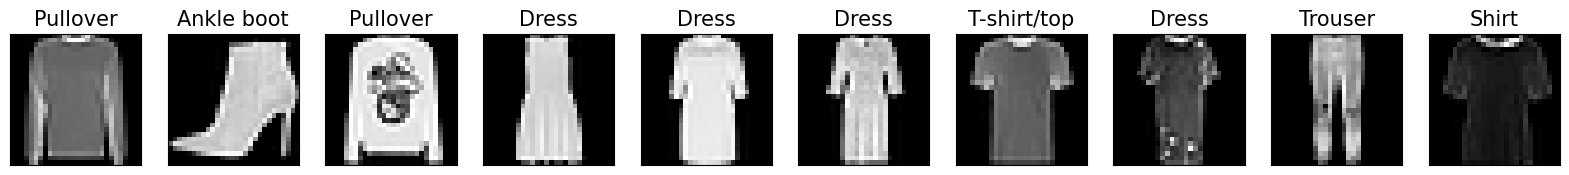

In [8]:
nsamples = 10
classes_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
imgs, labels = next(iter(train_loader))
imgs = imgs * std_ + mean_  # Get back of the normalization

fig = plt.figure(figsize=(20, 5), facecolor="w")
for i in range(nsamples):
    ax = plt.subplot(1, nsamples, i + 1)
    plt.imshow(imgs[i, 0, :, :], vmin=0, vmax=1.0, cmap=cm.gray)
    ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

We have now the data set ready. We can now define the model and the optimization model.

# Model definition

In [ ]:
class LinearClassificationModel(nn.Module):
    def __init__(self, n_features: int, n_classes: int):
        """n_feature is the number of pixel of the images: n_features = W*H"""
        super(LinearClassificationModel, self).__init__()
        self.n_features = n_features
        self.n_classes = n_classes
        self.layer = nn.Linear(self.n_features, self.n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, X: torch.Tensor)-> torch.Tensor:
        X = X.view(
            X.size()[0], -1
        )  # reshape the data as a long vector [batch_size, n_feature]
        y = self.layer(X)
        return y

    def predict_proba(self, X: torch.Tensor)-> torch.Tensor:
        y = self.forward(X)
        p = self.softmax(y)
        return p

    def predict(self, X: torch.Tensor)-> torch.Tensor:
        p = self.forward(X)
        c = torch.argmax(p, dim=1)
        return c

# Training the model

In [ ]:
n_epochs = 100
learning_rate = 0.0001
model = LinearClassificationModel(28 * 28, 10)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_set_len = len(train_loader)
val_set_len = len(valid_loader)
train_loss, val_loss = [], []

for epoch in range(n_epochs):
    model.train()
    accu = 0.0

    for X_, y_ in train_loader:
        # Forward pass
        y_hat = model(X_)
        loss = loss_fn(y_hat, y_)
        accu += loss.item()

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(accu / train_set_len)

    # Validation - no gradient & eval mode
    model.eval()
    accu = 0.0
    with torch.no_grad():
        for X_, y_ in valid_loader:
            # Forward pass
            y_hat = model(X_)
            loss = loss_fn(y_hat, y_)
            accu += loss.item()
        val_loss.append(accu / val_set_len)

In [ ]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.grid()

# To Do
- Compute the classification accuracy with the model (should be ~ 85%).
- Implement a check to save the best model w.r.t the validation loss and compare the accuracy of the "best" model with the "last" model.
- Take a wrongly classified image, and look at the probability membership for each class.